## Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

## Importing the dataset

In [2]:
data_train_raw = pd.read_csv('train.csv')
data_test_raw = pd.read_csv('test.csv')
data_train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Reordering columns, putting the target 'Survived' in the end

columns = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived']

data_train_raw = data_train_raw[columns]

In [4]:
# Name, ID and Ticket are only related to differentiating a passager from another, thus providing no predictive value
# They'll now be dropped from the dataset

data_test = data_test_raw.drop(['Name', 'PassengerId', 'Ticket'], axis = 1 )
data_train = data_train_raw.drop(['Name', 'PassengerId', 'Ticket'], axis = 1 )
data_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,male,22.0,1,0,7.2500,NaN,S,0
1,1,female,38.0,1,0,71.2833,C85,C,1
2,3,female,26.0,0,0,7.9250,NaN,S,1
3,1,female,35.0,1,0,53.1000,C123,S,1
4,3,male,35.0,0,0,8.0500,NaN,S,0


In [5]:
data_test['Cabin'].unique()
print('Different cabins: {}'.format(data_test['Cabin'].nunique()))

Different cabins: 76


The number of cabins probally won't add any predictive power to the model, since there are so many different variations. It would most likely only add variation to the model and it would be a good idea do discard it from the analysis, avoiding unnecessary complexity

In [6]:
data_test = data_test.drop(['Cabin'], axis = 1 )
data_train = data_train.drop(['Cabin'], axis = 1 )

## Dealing with missing values

In [7]:
# Checking general information
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
 7   Survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


There's some missing information in the dataset. There's a total of 891 entries, but two of them don't have the 'Embarked' info. We can simply discard those, since this small number is almost insignificant when compared to the total number of entries. 

However, there are 177 missing 'Age' entries and we have to deal with this issue. A good approach is to assign the mean age value, or even better, assign random age values that are close the the mean. 

In [8]:
# Discarding the missing 'Embark' info
data_train = data_train[data_train['Embarked'].notna()]

# Dealing with missing age values
age_mean = data_train['Age'].mean()
age_std = data_train['Age'].std()
missing_age = data_train['Age'].isnull().sum()

random_age = np.random.randint(age_mean - age_std, age_mean + age_std, missing_age)
ages = data_train['Age'].copy()
ages[np.isnan(ages)] = random_age
data_train['Age'] = ages
data_train['Age'] = data_train['Age'].astype(int)

In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


Our test data  has the same issue of missing age information and we'll do the same process here. Also, there's one 'Fare' data missing. Since we must have exactly 418 entries to evaluate the model, we can't simply discard it and thus we'll assign the mean value to it. 

In [10]:
# Dealing with missing age values
age_mean = data_test['Age'].mean()
age_std = data_test['Age'].std()
missing_age = data_test['Age'].isnull().sum()

random_age = np.random.randint(age_mean - age_std, age_mean + age_std, missing_age)
ages = data_test['Age'].copy()
ages[np.isnan(ages)] = random_age
data_test['Age'] = ages
data_test['Age'] = data_test['Age'].astype(int)

# Dealing with missing Fare valye
fare = data_test['Fare'].copy()
fare[np.isnan(fare)] = fare.mean()
data_test['Fare'] = fare

## Exploring the data

Here we'll explore the dataset a bit and see if we can draw some insights from it. First we'll check how gender can be used to determine if someone survives or not.

### Sex

In [11]:
women = data_train.loc[data_train.Sex == 'female']['Survived']
men = data_train.loc[data_train.Sex == 'male']['Survived']

women_surv = sum(women)/len(women)
men_surv = sum(men)/len(men)


print('{:.2%} of all women survived'.format(women_surv))
print('{:.2%} of all men survived'.format(men_surv))

74.04% of all women survived
18.89% of all men survived


This makes a lot of sense, considering women and children have preference when occupying the life saving boats. Hence, we could also infer that younger people would show a higher rate of survival. 

### Age

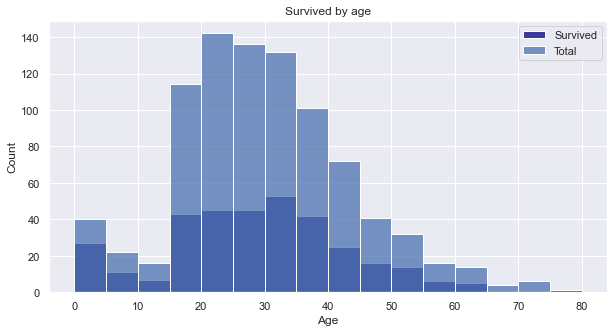

In [12]:
survived = data_train[data_train['Survived'] == 1]

fig, axes = plt.subplots(figsize = (10,5))
g = sns.histplot(survived['Age'], binwidth = 5, label = 'Survived', color ='navy')
g = sns.histplot(data_train['Age'], binwidth = 5, label = 'Total')
plt.title('Survived by age')
plt.legend()

The above plot is a great way to have an idea about how age relates to survival chances. Each bar represents an age group of 5 years. The darker color are the ones who survived and the lighter is the total number from that group. This means that the fueler each bar is, more people at that age survived. 

From that we can see that young children had indeed higher chances of surviving.

### Passanger Class

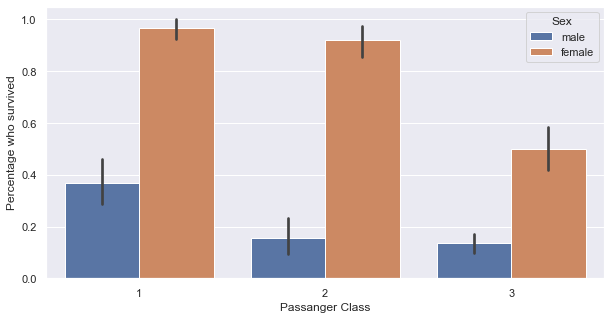

In [13]:
fig, axes = plt.subplots(figsize = (10,5))
g= sns.barplot(data=data_train, x='Pclass', y='Survived',hue='Sex')
g.set(xlabel='Passanger Class', ylabel='Percentage who survived')
plt.show()

Here's a really interesting insight: nearly every womam from the first and second class survived, while passangers from the third class had the lowest odds of suriving. Keep in mind that the bar plot does not calculate the actual percentage, but the mean of values, which for data exploration close is enough. 

### Siblings and spouse

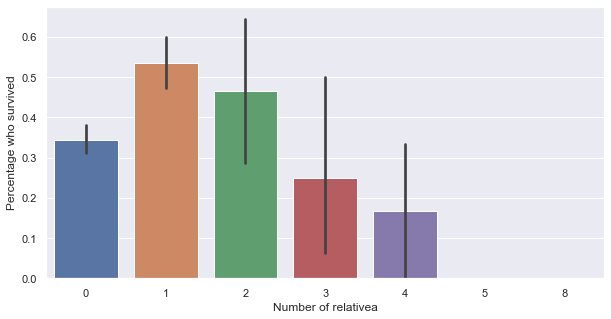

In [14]:
fig, axes = plt.subplots(figsize = (10,5))
g= sns.barplot(data=data_train, x='SibSp', y='Survived')
g.set(xlabel='Number of relativea', ylabel='Percentage who survived')
plt.show()

People with one relative had higher chances of survival, which decreased as this number increases. Here's how we could interpret this: it's unlikely that people below 20 years were traveling by themselves, so they are probablly with their parents (Nº Relavites > 0). Those with only one relative are probally couples in the majority, which quite interesting enough, had about 50% survival rate, implying that maybe the females survived. 

The vertical line indicates the error, since the barplot shows the mean value. If there are few observations, we could expect a larget error. 

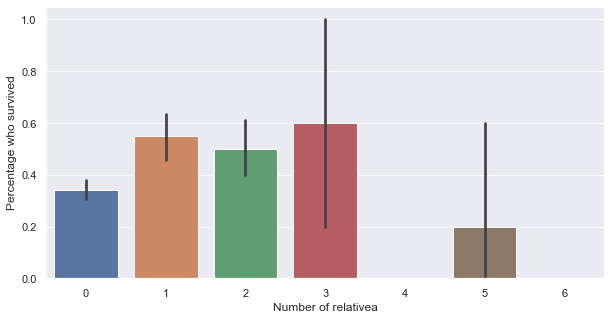

In [15]:
fig, axes = plt.subplots(figsize = (10,5))
g= sns.barplot(data=data_train, x='Parch', y='Survived')
g.set(xlabel='Number of relativea', ylabel='Percentage who survived')
plt.show()

### Fare

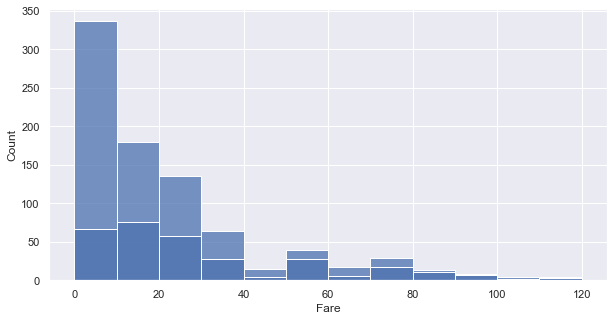

In [16]:
fig, axes = plt.subplots(figsize = (10,5))

# 'Fare' is highly skewed to the right, so we're going to filter some of the outliers for better visualization on the plot below
# Removing the top 5% outliers
q = data_train['Fare'].quantile(0.95)

g = sns.histplot(data_train[data_train['Fare'] < q]['Fare'],binwidth=10)
g = sns.histplot(data_train[(data_train['Fare']< q) & (data_train['Survived'] == 1)]['Fare'],binwidth=10)

Cheaper fares were more common and had lower surviving rates. However, this information is already contained in the passanger class data, since as noticed earlier, higher and therefore more expensive classes were more likely to present survivors. This means that these two features present multicolinearity and we may drop one of them. 

### Embarked

Those who embarked in Southampton had lower chanced of surviving. Quite interesting, this is also the location where most of the third class passangers embarked, who also had lower surviving rates. 

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

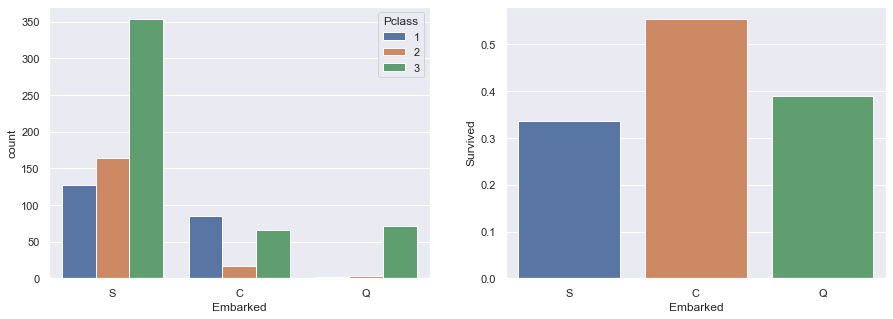

In [33]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))
# sns.countplot(data=data_train, x='Embarked', ax=ax1)
sns.countplot(data=data_train, x='Embarked', hue='Pclass', ax=ax1)
sns.barplot(data=data_train, x='Embarked', y='Survived',ci=None, ax=ax2)

## Preparing the model

In [19]:
# Checkpoint
data_train_1 = data_train.copy()
data_test_1 = data_test.copy()

In [20]:
# Encoding 'Sex' data
data_train_1['Sex'] = data_train_1['Sex'].map({'male':1,'female':0})
data_test_1['Sex'] = data_test_1['Sex'].map({'male':1,'female':0})

### Creating dummy variables

In [21]:
# Encoding 'Embarked'
embarked_dummies_train = pd.get_dummies(data_train_1['Embarked'], drop_first=True)
embarked_dummies_test = pd.get_dummies(data_test_1['Embarked'], drop_first=True)

data_train_2 = pd.concat([embarked_dummies_train,data_train_1],axis=1)
data_test_2 = pd.concat([embarked_dummies_test,data_test_1],axis=1)

data_train_2 = data_train_2.drop(['Embarked'], axis =1 )
data_test_2 = data_test_2.drop(['Embarked'], axis =1 )

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

columns_to_apply = ['Age']
data_train_2[columns_to_apply] = scaler.fit_transform(data_train_2[columns_to_apply])
data_test_2[columns_to_apply] = scaler.fit_transform(data_test_2[columns_to_apply])

Now that our data is encoded, we may perform a check reagarding multicolinearity

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = data_train_2[['Q', 'S', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['Features'] = variables.columns
vif

,VIF,Features
0,1.592533,Q
1,4.481140,S
2,6.338365,Pclass
3,3.020251,Sex
4,1.127247,Age
5,1.555475,SibSp
6,1.631448,Parch
7,1.368403,Fare


It doesn't seem like there's an issue with multicolinearity, since the VIF is lower than 5 for almost all variables, which is also a conservative value.

## Building the model

In [24]:
train_inputs = data_train_2.iloc[:,:-1]
train_targets = data_train_2.iloc[:,-1]

test_inputs = data_test_2.copy()

In [25]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression()
reg.fit(train_inputs,train_targets)

C:\Users\Bernardo\Documents\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [26]:
y_pred = reg.predict(train_inputs)

In [27]:
reg.score(train_inputs,train_targets)

0.8020247469066367

## Test

The final part is to prepare a submission file to be uploaded to the Kaggle Titanic Competition Website, which returns a score for the test dataset provided and our predictions. 

The current model has achieved a test accuracy of 0.76794. The next step would be experiment with other regression models and try to improve this value. 

In [28]:
y_pred_test =  reg.predict(test_inputs)

In [29]:
survivor_test = pd.DataFrame(y_pred_test)
submission = pd.concat([data_test_raw['PassengerId'],survivor_test], axis= 1)

In [30]:
header = ['PassengerID', 'Survived']
submission.to_csv('submission.csv', index=False, header=header)